In [3]:
import numpy as np
import xarray as xr
import stmat
import geopandas as gpd
import shapely as sp

Initialize raster coordinate information:

In [4]:
minx = 5 
maxx = 10
miny = 50
maxy = 55
dx = 0.5 #Resolution in x
dy = 0.5 #Resolution in y

nx = (maxx - minx)/dx
ny = (maxy - miny)/dy

xras = np.arange(minx, maxx, dx)
yras = np.arange(miny, maxy, dy)

xxras, yyras =np.meshgrid(xras,yras) #Raster meshgrid
print (xxras.shape)

(10, 10)


Create synthetic data 

In [5]:
n_points = 10000
n_time = 1

synthetic h2ph data

In [6]:
stack = np.empty((n_points,0))

for i in range(1):
    slc= np.random.random((100,100))
    stack = np.append(stack, slc[0:100,0:100].reshape(n_points,1), axis=1)

stack = np.array(stack*10, dtype='int')
print(stack.shape)


(10000, 1)


Case 1: synthetic coords (sorted in x and y)

In [7]:
x = np.sort(np.random.random(100)*(maxx - minx) + minx)
y = np.sort(np.random.random(100)*(maxy - miny) + miny)

In [8]:
xx, yy = np.meshgrid(x,y)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [9]:
stack_xx = np.empty((n_points,0))
stack_yy = np.empty((n_points,0))

for i in range(1):
    stack_xx = np.append(stack_xx, xxreshape, axis=1)
    stack_yy = np.append(stack_yy, yyreshape, axis=1)


Create Xarray object with coordinates as variables

In [10]:
data_xr = xr.Dataset(data_vars=dict(h2ph=(["points", "time"], stack), xv=(["points","time"],stack_xx),yv=(["points","time"],stack_yy),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr

<xarray.Dataset>
Dimensions:  (points: 10000, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * time     (time) int64 0
Data variables:
    h2ph     (points, time) int64 9 4 4 2 3 3 4 0 5 5 4 ... 1 9 4 5 8 7 8 3 9 8
    xv       (points, time) float64 5.048 5.23 5.261 5.281 ... 9.841 9.983 10.0
    yv       (points, time) float64 50.01 50.01 50.01 ... 54.99 54.99 54.99

Import rasterio and related module for rasterize

In [11]:
import rasterio
from rasterio import features
from rasterio import enums
import affine
import matplotlib.pyplot as plt

Convert xarray to geopandas data-frame for use in rasterize

In [12]:
df = data_xr.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.h2ph, geometry=gpd.points_from_xy(df.xv,df.yv))

gdf.sort_values('h2ph')

,h2ph,geometry
5473,0,POINT (8.46513 52.34732)
9705,0,POINT (5.30836 54.93435)
8807,0,POINT (5.34585 54.65638)
5476,0,POINT (8.49721 52.34732)
1348,0,POINT (7.27023 50.62962)
...,...,...
8943,9,POINT (6.94316 54.66076)
4849,9,POINT (7.28015 52.16526)
8941,9,POINT (6.84377 54.66076)
4340,9,POINT (6.81722 51.90252)


Convert point-set to raster using rasterize with point index as value

In [13]:
grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[9611. 9622. 9634. 9643. 9651. 9661. 9676. 9684. 9691. 9699.]
 [8411. 8422. 8434. 8443. 8451. 8461. 8476. 8484. 8491. 8499.]
 [8011. 8022. 8034. 8043. 8051. 8061. 8076. 8084. 8091. 8099.]
 [7111. 7122. 7134. 7143. 7151. 7161. 7176. 7184. 7191. 7199.]
 [6511. 6522. 6534. 6543. 6551. 6561. 6576. 6584. 6591. 6599.]
 [5411. 5422. 5434. 5443. 5451. 5461. 5476. 5484. 5491. 5499.]
 [4211. 4222. 4234. 4243. 4251. 4261. 4276. 4284. 4291. 4299.]
 [2911. 2922. 2934. 2943. 2951. 2961. 2976. 2984. 2991. 2999.]
 [2211. 2222. 2234. 2243. 2251. 2261. 2276. 2284. 2291. 2299.]
 [1011. 1022. 1034. 1043. 1051. 1061. 1076. 1084. 1091. 1099.]]


Visualize results

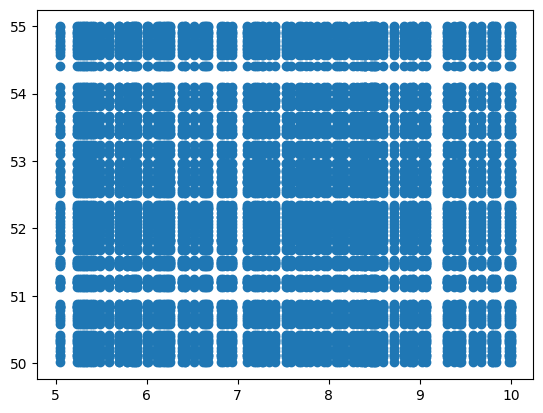

In [14]:
plt.scatter(data_xr.xv, data_xr.yv) #Original complete data-set

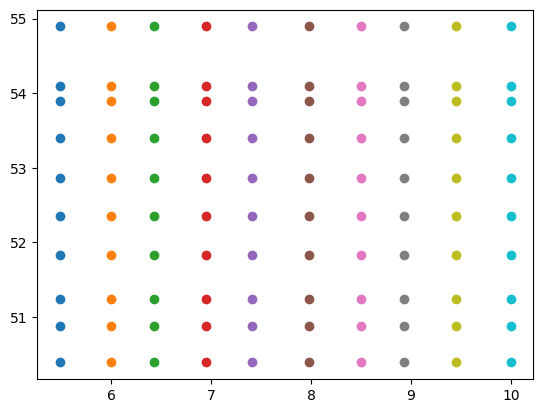

In [15]:
#Plotting subset after densification
for i in np.unique(raster):
    if i is not np.nan:
        plt.scatter(data_xr.xv[np.int64(i)], data_xr.yv[np.int64(i)])
        

Case 2: Clusters of points

In [16]:
n_points = 400
n_time = 1

In [17]:
xx = (np.random.random(400)*(maxx - minx) + minx)
yy = (np.random.random(400)*(maxy - miny) + miny)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [18]:
stack_xx_c2 = np.empty((n_points,0))
stack_yy_c2 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c2 = np.append(stack_xx_c2, xxreshape, axis=1)
    stack_yy_c2 = np.append(stack_yy_c2, yyreshape, axis=1)

data_xr_c2 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c2),yv=(["points","time"],stack_yy_c2),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c2

<xarray.Dataset>
Dimensions:  (points: 400, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 7.518 5.015 8.176 ... 7.913 8.913 7.751
    yv       (points, time) float64 51.68 52.0 52.64 51.58 ... 54.4 54.56 53.41

In [19]:
df = data_xr_c2.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[288. 347. 371. 338. 284. 397. 276. 398. 381. 361.]
 [317. 348. 394.  29. 366. 332. 299. 328. 395. 346.]
 [345. 290. 352. 282. 330. 399. 396. 200. 291. 118.]
 [372. 389. 121. 303. 376. 283. 343. 240. 368. 297.]
 [342. 323. 301. 311. 377. 350. 388. 266. 375. 370.]
 [289. 393. 226. 373. 258.  nan 364. 260. 314. 379.]
 [312. 319. 382. 362. 305. 309. 307.  26. 387. 357.]
 [275. 279. 358. 383. 236. 337. 391. 327. 360. 320.]
 [221.  nan 211. 384. 253. 335. 277. 245. 336. 244.]
 [333. 104. 386. 392. 365. 340. 363. 367. 355.  22.]]


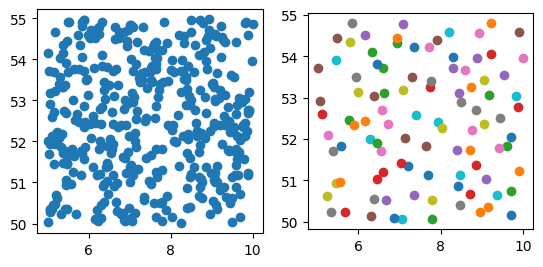

In [20]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c2.xv, data_xr_c2.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c2.xv[np.int64(i)], data_xr_c2.yv[np.int64(i)])

Case 3: Clustered points around 3 regions

In [39]:
n_points = 900
n_time = 1

#Defining mean for clustering around
xmeans = [5.5, 8.5, 7]
ymeans = [51, 53, 54.5]
xvar = 2
yvar = 2

xxreshape = np.empty((n_points,1))
yyreshape = np.empty((n_points,1))

xxreshape[0:300,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[0])
yyreshape[0:300,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[0])

xxreshape[300:600,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[1])
yyreshape[300:600,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[1])

xxreshape[600:900,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[2])
yyreshape[600:900,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[2])

#xxreshape = xx.reshape(n_points,1)
#yyreshape = yy.reshape(n_points,1)

In [40]:
stack_xx_c3 = np.empty((n_points,0))
stack_yy_c3 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c3 = np.append(stack_xx_c3, xxreshape, axis=1)
    stack_yy_c3 = np.append(stack_yy_c3, yyreshape, axis=1)

data_xr_c3 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c3),yv=(["points","time"],stack_yy_c3),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c3

<xarray.Dataset>
Dimensions:  (points: 900, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 892 893 894 895 896 897 898 899
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 5.336 4.81 4.841 5.931 ... 7.745 6.48 6.141
    yv       (points, time) float64 51.18 50.95 51.56 50.42 ... 54.8 53.79 53.71

In [42]:
df = data_xr_c3.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[ nan  nan 888. 893. 885. 897.  nan  nan  nan  nan]
 [ nan  nan 853. 884. 891. 877. 589. 569. 554.  nan]
 [ nan  nan 899. 892. 857. 890. 564. 598. 567.  nan]
 [ nan  nan  nan  nan  nan 587. 582. 578. 591.  nan]
 [ nan  nan  nan  nan  nan 585. 594. 584. 563.  nan]
 [ nan 296. 252.  nan  nan 550. 599. 590. 592.  nan]
 [283. 295. 292.  nan  nan  nan  nan  nan  nan  nan]
 [275. 263. 281.  nan  nan  nan  nan  nan  nan  nan]
 [291. 289. 287.  nan  nan  nan  nan  nan  nan  nan]
 [290. 285. 297.  nan  nan  nan  nan  nan  nan  nan]]


(45,)


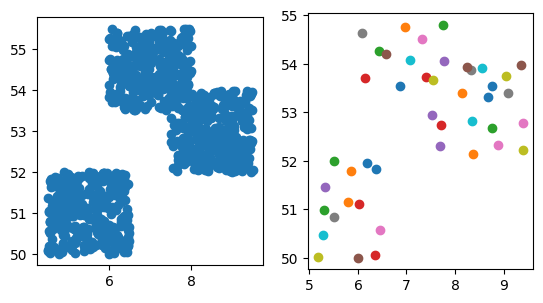

In [45]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c3.xv, data_xr_c3.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c3.xv[np.int64(i)], data_xr_c3.yv[np.int64(i)])

print (np.unique(raster).shape)